In [ ]:
import sys 
import os

sys.path.append(os.path.abspath("/scratch/xl01339/Enhancing_Sketch-to-3D_Controllability"))

import torch
from tqdm.notebook import trange
from pytorch_lightning import seed_everything
from PIL import Image
from torchvision import transforms

from src.utils.spaghetti_util import generate_zc_from_sj_gaus, load_spaghetti, load_marching_cube_meshing, get_mesh_from_spaghetti
from src.utils.visual_util import render_gaussians, render_mesh
from src.utils.image_util import merge_images
from configs.log_config import logger
from src.utils.train_util import load_model
from configs.global_setting import DATA_DIR, BASE_DIR, device
from src.models.stage1 import Stage1Model
from src.models.stage2 import Stage2Model

# Load models

In [2]:
logger.info('Loading models...')
# time_folder = "0704_190915"
time_folder = "0705_095409"
stage1_model = load_model(time_folder, Stage1Model, "stage1", device)
stage2_model = load_model(time_folder, Stage2Model, "stage2", device)

stage1_model._build_dataset("val")

2025-07-05 16:53:25,264 - INFO - Loading models...
/scratch/xl01339/miniconda3/envs/sketch3d/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['network'])`.
/scratch/xl01339/miniconda3/envs/sketch3d/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'variance_schedule' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['variance_schedule'])`.
2025-07-05 16:53:26,913 - INFO - global_mean shape: (16,)
2025-07-05 16:53:26,914 - INFO - global_std shape: (16,)
2025-07-05 16:53:27,077 - INFO - g_js_affine shape: (5401, 16, 16)
2025-07-05 16:53:27,129 - INFO - The amount of sketch files: 0
2025-07-05 16:53:27,206 - INFO - The amount of sketch files: 6778


# Sample extrinsic parameters and intrinsic latents.

In [3]:
seed_everything(2025)
test_images = ['informative_drawings_sketches/opensketch_style/1a6f615e8b1b5ae4dbbc9440457e303e_view_-60_out.png']

logger.info('Start sampling...')
# Stage1 sampling
extrinsics = stage1_model.sampling_gaussians(test_images)

# stage2 sampling
intrinsics = stage2_model.sample(test_images, extrinsics)

Seed set to 2025
2025-07-05 17:00:57,017 - INFO - Start sampling...
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 149.36it/s]


# Generate latents with SPAGHETTI

In [4]:
tag_name = 'chairs_large'
spaghetti = load_spaghetti(device=device, tag=tag_name)
zcs = generate_zc_from_sj_gaus(spaghetti, intrinsics, extrinsics)

/scratch/xl01339/miniconda3/envs/sketch3d/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
2025-07-05 17:01:22,470 - INFO - ******************************
2025-07-05 17:01:22,470 - INFO - loading spaghetti model from /scratch/xl01339/Enhancing_Sketch-to-3D_Controllability/assets/checkpoints/spaghetti_chairs_large/model
2025-07-05 17:01:22,471 - INFO - ******************************
/scratch/xl01339/miniconda3/envs/sketch3d/lib/python3.11/site-packages/spaghetti/utils/train_utils.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more det

# Visualization for results

2025-07-05 17:01:26,020 - INFO - Rendering results...


  0%|          | 0/1 [00:00<?, ?it/s]

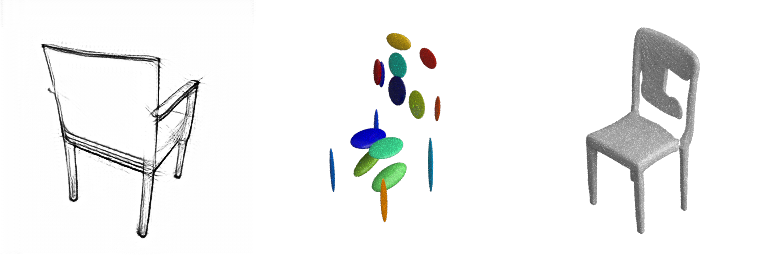

In [ ]:
# Initialize mesher
mc_mesher = load_marching_cube_meshing(device=device)

logger.info('Rendering results...')
# Visualization for results
data_name = 'predictions'
save_dir = str(BASE_DIR / f'output/dataset_visual_images/{data_name}_v1/')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
k = 256
image_res = (k, k)

image_transform = transforms.Compose([transforms.Resize(image_res),])

images = []
for i in trange(len(zcs)):
    gaus_img = render_gaussians(extrinsics[i], resolution=image_res)

    v, f = get_mesh_from_spaghetti(spaghetti, mc_mesher, zcs[i], res=k)
    mesh_img = render_mesh(v, f, resolution=image_res)

    sketch_path = test_images[i]
    sketch_img = Image.open(DATA_DIR / sketch_path).convert('RGB')
    sketch_img = image_transform(sketch_img)
    save_path = save_dir + f'render_mesh_{i}.png'
    img = merge_images([sketch_img, gaus_img, mesh_img], save_path)
    display(img)
    images.append([img])
# merge_images(images)